# Import Libraries

In [24]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, auc
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier

# Loading Dataset

In [10]:
# Load dataset
df = pd.read_csv('/kaggle/input/fraud-detection/creditcard.csv')

# Quick look at class distribution
print(df['Class'].value_counts())
df.head()


Class
0    284315
1       492
Name: count, dtype: int64


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


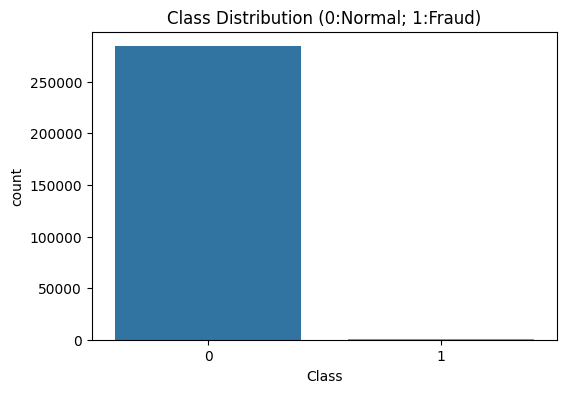

In [12]:
# Plot class imbalance
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Class')
plt.title('Class Distribution (0:Normal; 1:Fraud)')
plt.show()

In [14]:

# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Handling Class Imbalance - Undersampling

In [16]:
# Handle Class Imbalance - Undersampling
# ===========================
fraud_indices = np.array(df[df.Class == 1].index)
normal_indices = df[df.Class == 0].index

In [17]:
# Randomly pick normal transactions equal to fraud cases
random_normal_indices = np.random.choice(normal_indices, len(fraud_indices), replace=False)

In [18]:
# Combine to create a balanced dataset
under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])
under_sample_data = df.iloc[under_sample_indices, :]

X_under = under_sample_data.drop('Class', axis=1)
y_under = under_sample_data['Class']

# Train-Test Split

In [19]:
# Train-Test Split
# ===========================
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.3, random_state=42)

# Feature Scaling
# ===========================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model 1: Logistic Regression

In [42]:
# Model 1: Logistic Regression
# ===========================
print("\nTraining Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
y_proba_lr = lr_model.predict_proba(X_test)[:, 1]


Training Logistic Regression...


# Model 2: Random Forest with GridSearch

In [43]:
# Model 2: Random Forest with GridSearch
# ===========================
print("\nTuning Random Forest Classifier with GridSearch...")

rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [4, 6, 8, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_base = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf_base, rf_param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)

print("\nBest Random Forest Parameters:", rf_grid.best_params_)

rf_best = rf_grid.best_estimator_
y_pred_rf = rf_best.predict(X_test)
y_proba_rf = rf_best.predict_proba(X_test)[:, 1]


Tuning Random Forest Classifier with GridSearch...
Fitting 3 folds for each of 32 candidates, totalling 96 fits

Best Random Forest Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


# Model 3: XGBoost with GridSearch

In [44]:
# Model 3: XGBoost with GridSearch
# ===========================
print("\nTuning XGBoost Classifier with GridSearch...")

xgb_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2]
}

xgb_base = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_grid = GridSearchCV(xgb_base, xgb_param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)
xgb_grid.fit(X_train, y_train)

print("\nBest XGBoost Parameters:", xgb_grid.best_params_)

xgb_best = xgb_grid.best_estimator_
y_pred_xgb = xgb_best.predict(X_test)
y_proba_xgb = xgb_best.predict_proba(X_test)[:, 1]


Tuning XGBoost Classifier with GridSearch...
Fitting 3 folds for each of 36 candidates, totalling 108 fits

Best XGBoost Parameters: {'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 150}


# Model Evaluation

In [45]:
# Evaluation Function
# ===========================
def evaluate_model(name, y_test, y_pred, y_proba):
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    
    print(f"\n{name} Classification Report:\n", classification_report(y_test, y_pred))
    print(f"{name} Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return [acc, prec, rec, f1, roc]


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.92       146
           1       0.94      0.89      0.92       150

    accuracy                           0.92       296
   macro avg       0.92      0.92      0.92       296
weighted avg       0.92      0.92      0.92       296

Logistic Regression Confusion Matrix:
 [[138   8]
 [ 16 134]]


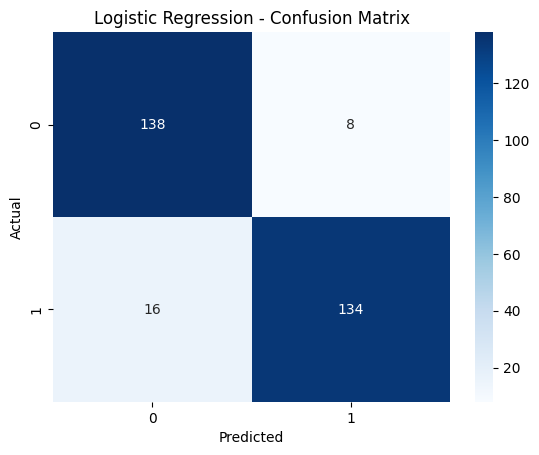


Random Forest (Tuned) Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.99      0.94       146
           1       0.99      0.89      0.94       150

    accuracy                           0.94       296
   macro avg       0.94      0.94      0.94       296
weighted avg       0.94      0.94      0.94       296

Random Forest (Tuned) Confusion Matrix:
 [[144   2]
 [ 16 134]]


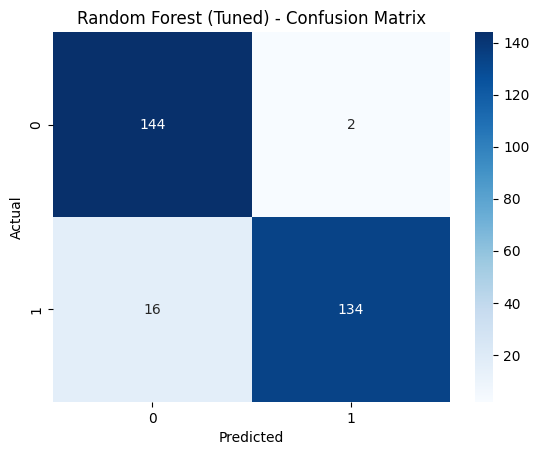


XGBoost (Tuned) Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       146
           1       0.97      0.91      0.94       150

    accuracy                           0.94       296
   macro avg       0.94      0.94      0.94       296
weighted avg       0.94      0.94      0.94       296

XGBoost (Tuned) Confusion Matrix:
 [[142   4]
 [ 14 136]]


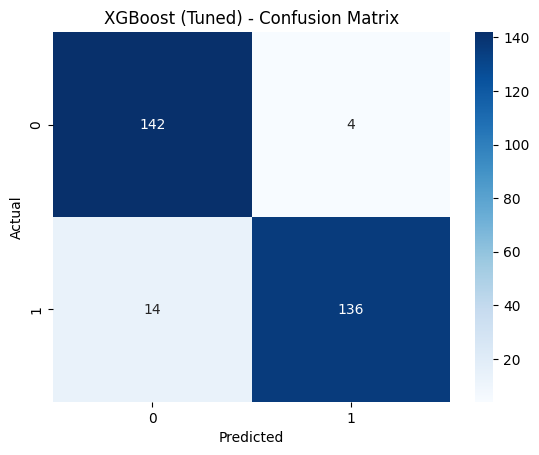

In [46]:
# Evaluate All Models
# ===========================
results = {}

results['Logistic Regression'] = evaluate_model('Logistic Regression', y_test, y_pred_lr, y_proba_lr)
results['Random Forest (Tuned)'] = evaluate_model('Random Forest (Tuned)', y_test, y_pred_rf, y_proba_rf)
results['XGBoost (Tuned)'] = evaluate_model('XGBoost (Tuned)', y_test, y_pred_xgb, y_proba_xgb)

In [47]:
# Comparison Table
# ===========================
results_df = pd.DataFrame(results, index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']).T
print("\nModel Performance Comparison:")
print(results_df)


Model Performance Comparison:
                       Accuracy  Precision    Recall  F1 Score   ROC-AUC
Logistic Regression    0.918919   0.943662  0.893333  0.917808  0.969680
Random Forest (Tuned)  0.939189   0.985294  0.893333  0.937063  0.980639
XGBoost (Tuned)        0.939189   0.971429  0.906667  0.937931  0.983744


# Plotting ROC Curves

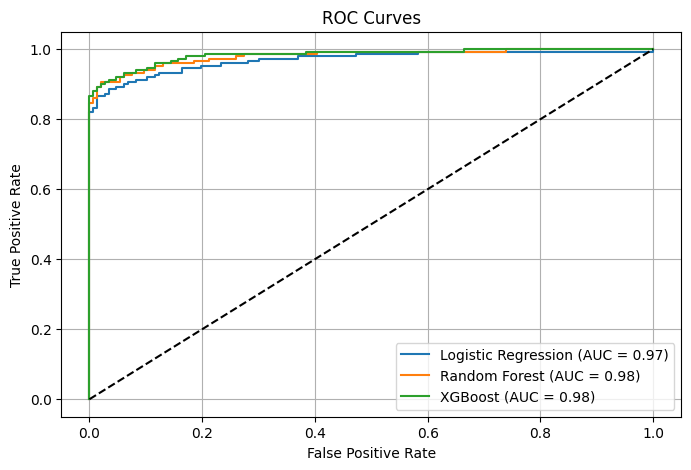

In [51]:
# Plot ROC Curves
# ===========================
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

plt.figure(figsize=(8, 5))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_proba_lr):.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_proba_rf):.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_test, y_proba_xgb):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Plotting Precision-Recall curves

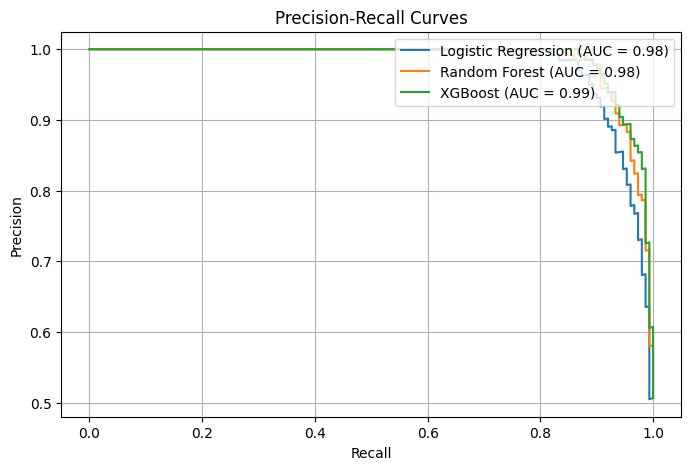

In [52]:
# Plot Precision-Recall Curves
# ===========================
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_proba_lr)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_proba_rf)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_proba_xgb)

plt.figure(figsize=(8, 5))
plt.plot(recall_lr, precision_lr, label=f'Logistic Regression (AUC = {auc(recall_lr, precision_lr):.2f})')
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AUC = {auc(recall_rf, precision_rf):.2f})')
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost (AUC = {auc(recall_xgb, precision_xgb):.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='upper right')
plt.grid()
plt.show()

# Conclusion

1. All three models performed well, but Random Forest and XGBoost significantly outperformed Logistic Regression in most metrics.
2. **Random Forest (Tuned)** achieved the **highest precision (0.985)**, making it highly effective at minimizing false positives.
3. **XGBoost (Tuned)** provided the best balance between precision and recall, achieving the **highest F1 Score (0.938)** and the **highest ROC-AUC (0.984)**, indicating excellent discriminatory power.
4. Logistic Regression, despite being a simpler model, still achieved a competitive **ROC-AUC of 0.970**, showing it can be a strong baseline for this problem.
5. **All models maintained a recall around 0.89–0.91**, meaning they consistently detected most fraudulent cases.

***ROC and Precision-Recall curves confirmed XGBoost as the most balanced and reliable model for this dataset.***